# Deep Convolution Generative Adversarial Network

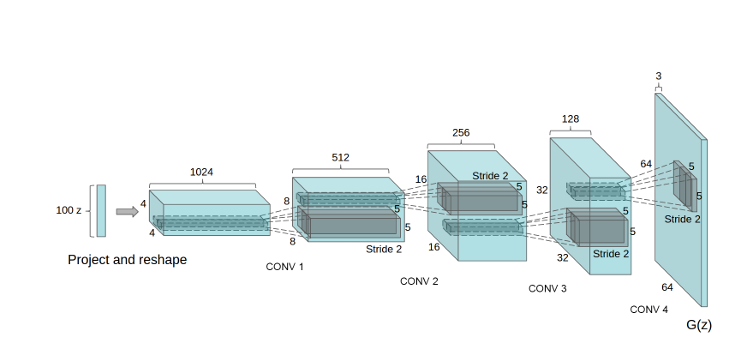

#### Import Librarires

In [1]:
import torch
import torch.nn as nn

## Discriminator Class

- features_d will be the channels that are going to change as the image flows through the layers of the Discriminator
- In the paper BatchNorm() is not used in the first layer of the Discriminator and the last layer of the Generator
- We use Conv2d(with out_channels = 1) as the last layer of the Discriminator because we want a single value which will tell whether the image is real or fake 

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            #Input Image shape:  N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1), #Shape: N x channels_img x 64x64-------->N x features_d x 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4,2,1),   #Shape: 32x32-------->16x16
            self._block(features_d*2, features_d*4, 4,2,1), #Shape: 16x16-------->8x8
            self._block(features_d*4, features_d*8, 4,2,1), #Shape: 8x8-------->4x4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), #Shape: 4x4-------->1x1
            nn.Sigmoid()
        )
    
    def _block(self, in_channels, out_channels, kernel_size ,stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),          
        )
    
    def forward(self, x):
        return self.disc(x)
    

## Generator Class 

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gene = nn.Sequential(
            #Input Shape: N x z_dim X 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), #Shape: N x z_dim x 1 x 1----------> N x features_g*16 x 4 x 4 
            self._block(features_g*16, features_g*8, 4, 2 , 1), #Shape: 4 x 4-------------> 8 x 8
            self._block(features_g*8, features_g*4, 4, 2 ,1),   #Shape: 8 x 8 ------------> 16 x 16
            self._block(features_g*4, features_g*2, 4, 2 ,1),   #Shape: 16 x 16-----------> 32 x 32
            
            #For the final layer we will not use _block() as we don't want to have batchNorm() at the last layer of Generator()
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), #Shape: 32 x 32---------> 64 x 64
            nn.Tanh()
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.gene(x)

#### Function to Initialize Weigths of a Particular Model

- We will initialize weights by having MEAN 0 and STANDARD_DEVIATION 0.02

In [7]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.BatchNorm2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        

#### Function to test for Errors in the architecture of the DCGAN 

In [12]:
def test():
    N, in_channles, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channles, H, W))
    disc = Discriminator(in_channles, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N,1,1,1)
    gene = Generator(z_dim, in_channles, 8)
    z = torch.randn((N, z_dim, 1, 1))
    initialize_weights(gene)
    assert gene(z).shape == (N,in_channles, H, W)
    
    print("No Error Present")

test()

No Error Present
